# Импорты и конфиг

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC

# reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Загрузка dataset (подгоняем под ResNet50: 224×224)

In [2]:
# Пути
train_dir = "datasets/RAF/dataset/train"
val_dir = "datasets/RAF/dataset/test"

# Параметры
img_size = (224, 224)
batch_size = 32
seed = 42

# Ограничения (если None – берём все данные)
train_limit = None   # например, 500 изображений
val_limit   = None   # например, 200 изображений

# Создаём tf.data наборы
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

# Ограничиваем число сэмплов, если задан train_limit / val_limit
if train_limit is not None:
    train_ds = train_ds.unbatch().take(train_limit).batch(batch_size)

if val_limit is not None:
    val_ds = val_ds.unbatch().take(val_limit).batch(batch_size)

Found 12271 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.
Class names: ['1', '2', '3', '4', '5', '6', '7']


# Предобработка (используем preprocess_input для ResNet50) и prefetch

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

# preprocess_input приведёт данные в вид, подходящий для ResNet50
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# быстро посмотрим одну пачку
for imgs, labels in train_ds.take(1):
    print("batch images shape:", imgs.shape)
    print("batch labels:", labels.numpy()[:10])

batch images shape: (32, 224, 224, 3)
batch labels: [4 4 2 2 6 3 6 3 3 4]


# Посчитать распределение классов (sanity check)

In [4]:
# Собираем все метки (эффективно — батчами)
train_labels = np.concatenate([y.numpy() for x, y in train_ds.unbatch().batch(2048)])
val_labels = np.concatenate([y.numpy() for x, y in val_ds.unbatch().batch(2048)])
print("Train class counts:", np.bincount(train_labels))
print("Val   class counts:", np.bincount(val_labels))

Train class counts: [1290  281  717 4772 1982  705 2524]
Val   class counts: [ 329   74  160 1185  478  162  680]


# Создаём ResNet50 (backbone) и печатаем summary

In [5]:
# ResNet50 без голова, pooling='avg' даёт вектор признаков (2048-d)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
resnet.trainable = False  # заморозим — мы берем только эмбеддинги
# resnet.summary()

# Функция извлечения эмбеддингов и их получение (можно сохранить на диск)

In [6]:
def dataset_to_embeddings(dataset, model, verbose=True):
    X_list, y_list = [], []
    for batch_images, batch_labels in dataset:
        emb = model.predict(batch_images, verbose=0)  # (batch_size, 2048)
        X_list.append(emb)
        y_list.append(batch_labels.numpy())
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

# Извлекаем эмбеддинги (может занять некоторое время на CPU)
X_train, y_train = dataset_to_embeddings(train_ds, resnet)
X_val,   y_val   = dataset_to_embeddings(val_ds, resnet)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape,   "y_val   shape:", y_val.shape)

# Сохраним, чтобы не пересчитывать при отладке
np.save("X_train_resnet.npy", X_train)
np.save("y_train_resnet.npy", y_train)
np.save("X_val_resnet.npy", X_val)
np.save("y_val_resnet.npy", y_val) 
# 4000 + 1000  --  320 сек
# полный датасет  --  12 минут

X_train shape: (12271, 2048) y_train shape: (12271,)
X_val   shape: (3068, 2048) y_val   shape: (3068,)


# PCA — понижаем размерность (2048 → 128)

In [7]:
pca_components = 128  # можно пробовать 64, 128, 256
pca = PCA(n_components=pca_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
print("After PCA shapes:", X_train_pca.shape, X_val_pca.shape)

After PCA shapes: (12271, 128) (3068, 128)


# Baseline: LogisticRegression на PCA-эмбеддингах (быстро)

c:\Users\ngold\miniconda3\envs\SciencePaper-GumTec\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ngold\miniconda3\envs\SciencePaper-GumTec\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (LogReg): 0.6205997392438071
              precision    recall  f1-score   support

           0     0.5842    0.5167    0.5484       329
           1     0.5918    0.3919    0.4715        74
           2     0.3273    0.1125    0.1674       160
           3     0.7070    0.8228    0.7605      1185
           4     0.5509    0.4979    0.5231       478
           5     0.5077    0.4074    0.4521       162
           6     0.5574    0.6000    0.5779       680

    accuracy                         0.6206      3068
   macro avg     0.5466    0.4785    0.5001      3068
weighted avg     0.6033    0.6206    0.6061      3068



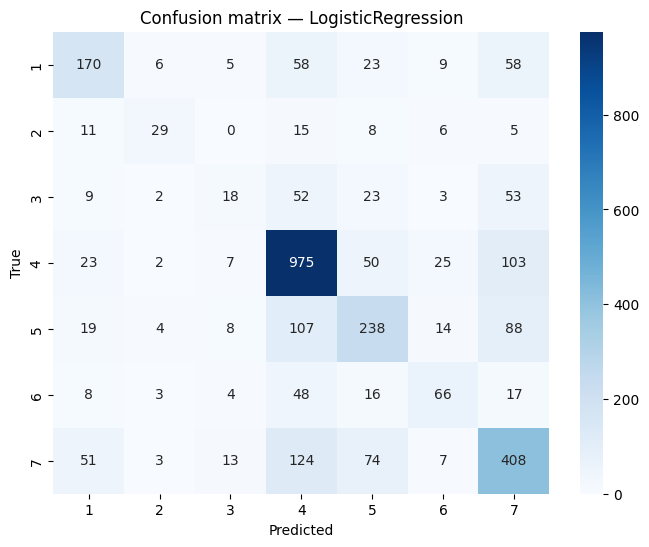

In [8]:
# LogisticRegression (multinomial). Сначала -> без class_weight
clf = LogisticRegression(max_iter=5000, solver='saga', multi_class='multinomial', C=1.0)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_val_pca)
print("Accuracy (LogReg):", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix — LogisticRegression")
plt.show()

# LogisticRegression с class_weight='balanced' (для сравнения)

c:\Users\ngold\miniconda3\envs\SciencePaper-GumTec\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ngold\miniconda3\envs\SciencePaper-GumTec\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (LogReg balanced): 0.5514993481095176
              precision    recall  f1-score   support

           0     0.5134    0.5805    0.5449       329
           1     0.2090    0.5676    0.3055        74
           2     0.1853    0.4250    0.2581       160
           3     0.8488    0.6489    0.7355      1185
           4     0.5385    0.4393    0.4839       478
           5     0.3180    0.5556    0.4045       162
           6     0.5865    0.4735    0.5240       680

    accuracy                         0.5515      3068
   macro avg     0.4571    0.5272    0.4652      3068
weighted avg     0.6283    0.5515    0.5762      3068



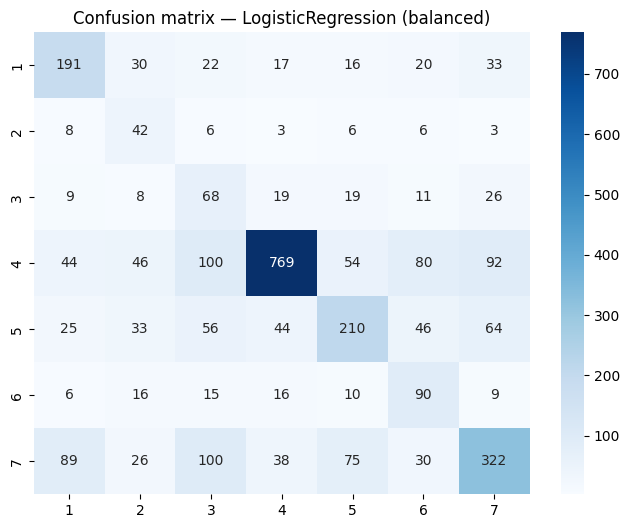

In [9]:
clf_bal = LogisticRegression(max_iter=5000, solver='saga', multi_class='multinomial', class_weight='balanced')
clf_bal.fit(X_train_pca, y_train)

y_pred_bal = clf_bal.predict(X_val_pca)
print("Accuracy (LogReg balanced):", accuracy_score(y_val, y_pred_bal))
print(classification_report(y_val, y_pred_bal, digits=4))

cm = confusion_matrix(y_val, y_pred_bal)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion matrix — LogisticRegression (balanced)")
plt.show()

# LinearSVC (быстрее, часто устойчивее) и при желании RBF-SVM (медленно)

LinearSVC acc: 0.5919165580182529
              precision    recall  f1-score   support

           0     0.5132    0.5897    0.5488       329
           1     0.2969    0.5135    0.3762        74
           2     0.2108    0.2188    0.2147       160
           3     0.7694    0.7460    0.7575      1185
           4     0.5581    0.4623    0.5057       478
           5     0.3710    0.5062    0.4282       162
           6     0.5746    0.5324    0.5527       680

    accuracy                         0.5919      3068
   macro avg     0.4706    0.5098    0.4834      3068
weighted avg     0.6043    0.5919    0.5956      3068



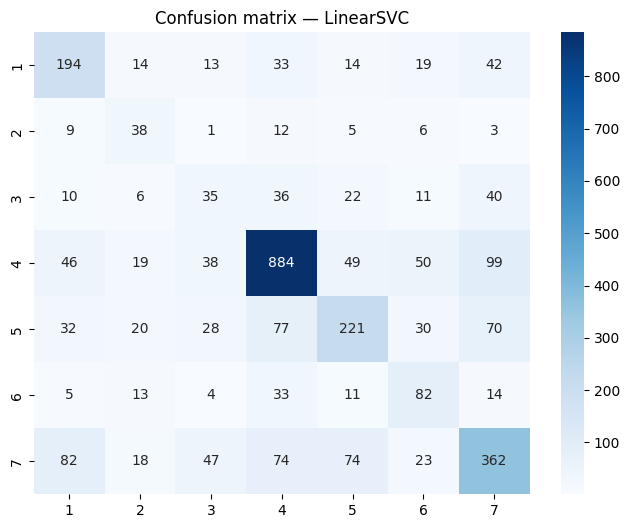

In [10]:
# LinearSVC — обычно быстро и устойчиво
svc_lin = LinearSVC(max_iter=10000, class_weight='balanced')
svc_lin.fit(X_train_pca, y_train)
y_pred_lin = svc_lin.predict(X_val_pca)
print("LinearSVC acc:", accuracy_score(y_val, y_pred_lin))
print(classification_report(y_val, y_pred_lin, digits=4))

cm = confusion_matrix(y_val, y_pred_lin)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion matrix — LinearSVC")
plt.show()

# ----- ВНИМАНИЕ: RBF-SVM (SVC) может быть очень медленным на большом количестве примеров -----
# Если хочешь запустить — используй небольшую подвыборку или PCA до 64 компонент.
# Пример (может занять много времени):
# svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
# svc_rbf.fit(X_train_pca, y_train)
# y_pred_rbf = svc_rbf.predict(X_val_pca)
# print("RBF SVM acc:", accuracy_score(y_val, y_pred_rbf))

# Пояснения и практические советы

preprocess_input — важен: мы используем специально для ResNet50 (центровка/масштабирование).

PCA обычно помогает SVM/LogisticRegression и уменьшает шум — рекомендую n_components=64..256, тестируй.

class_weight='balanced' — полезно, но не магия; иногда приводит к нестабильности (особенно с плохими признаками). С ResNet признаки обычно лучше, чем FaceNet, так что balanced может помочь, но сравни оба варианта.

RBF SVM может быть очень медленным на >1k–10k примерах; для больших наборов лучше LinearSVC / LogisticRegression / LightGBM.

Fine-tuning ResNet (добавить голову и дообучить) часто даёт наилучший прирост, но требует больше времени.

Если в изображениях лица сильно не выровнены — сначала детектируй и выравнивай (MTCNN/dlib), это улучшит результат.